In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
# Load data
df = pd.read_csv('drive/MyDrive/sentiment.csv')
df.head()

,sentence,label
0,Ok brokeback mountain is such a horrible movie.,0
1,Brokeback Mountain was so awesome.,1
2,friday hung out with kelsie and we went and sa...,0
3,I am going to start reading the Harry Potter s...,1
4,"Is it just me, or does Harry Potter suck?...",0


In [3]:
# Split the data into train, validation and test data
train_text, temp_text, train_labels, temp_labels = train_test_split(
    df['sentence'],
    df['label'],
    random_state=2024,
    test_size=0.3,
    stratify=df['label'])
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text,
    temp_labels,
    random_state=2024,
    test_size=0.5,
    stratify=temp_labels)

In [4]:
# Load model and tokenizer
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(array([1467.,  721.,  570.,  533.,  159.,  218.,  117.,   61.,  115.,
           6.]),
 array([ 3. ,  6.5, 10. , 13.5, 17. , 20.5, 24. , 27.5, 31. , 34.5, 38. ]),
 <BarContainer object of 10 artists>)

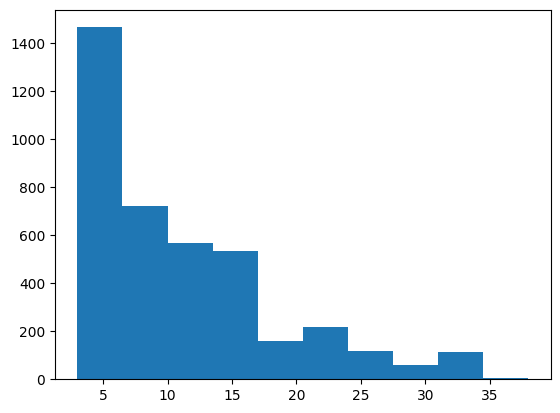

In [5]:
# Determine padding length
train_lens = [len(i.split()) for i in train_text]
plt.hist(train_lens)

In [6]:
# tokenize and encode sequences
pad_len = 17
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=pad_len,
    truncation=True,
    padding=True
    )
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=pad_len,
    truncation=True,
    padding=True
    )
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=pad_len,
    truncation=True,
    padding=True
    )

tokens_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [7]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

In [8]:
train_dataset = torch.utils.data.TensorDataset(train_seq, train_mask, train_y)
val_dataset = torch.utils.data.TensorDataset(val_seq, val_mask, val_y)

In [9]:
train_dataset[0]

(tensor([  101,  1996,  2466,  1997,  4302, 10693,  2003,  1037,  2784,  1998,
         13769,  2028,  1010,  1998,  1045,  2293,   102]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor(1))

In [12]:
# Defining the model (freeze pretained layers and add new layers)

# Freeze the pretrained layers
for param in bert.parameters():
    param.requires_grad = False

# Define new layers
class BERT_architecture(nn.Module):
  """
  BERT_architecture
  """
  def __init__(self, bert):
    """
    Constructor
    """
    super().__init__()
    self.bert = bert
    # dropout layer
    self.dropout = nn.Dropout(p=0.1)
    # relu activation function
    self.relu =  nn.ReLU()
    # dense layer
    self.fc1 = nn.Linear(768,512)
    self.fc2 = nn.Linear(512,2) # output layer
    # softmax activation function
    self.softmax = nn.LogSoftmax(dim=1)

  # Define the forward pass
  def forward(self, sent_id, mask):
    """
    Forward pass
    """
    # Pass the inputs to the model
    _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
    #import pdb; pdb.set_trace()
    x = self.fc1(cls_hs)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x) # output layer
    x = self.softmax(x)
    return x

In [13]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [48]:
# Function to train the model
def train(n_epochs=10, batch_size=16):
  """
  Train the model
  """
  model.train()
  train_dataloader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
  )
  n_train = len(train_dataloader)

  for epoch in range(1, n_epochs+1):
    print(f'Epoch {epoch}: ', end='')
    total_loss = 0.0
    accuracies = []
    n_points = 0

    # Iterate over batches
    for step, batch in enumerate(train_dataloader):
      # Push the batch to GPU
      batch = (r.to(device) for r in batch)
      sent_id, mask, labels = batch
      # Clear out the gradients
      optimizer.zero_grad()
      # Get model predictions for the current batch
      preds = model(sent_id, mask)
      # Calculate the classification loss
      loss = torch.nn.functional.cross_entropy(preds, labels)
      total_loss = total_loss + loss.item()
      # Backward pass to calcualte the gradients
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      # Update parameters and take a step using the computed gradient
      optimizer.step()

      # Calculate the accuracy
      preds = preds.detach().cpu().numpy()
      pred_labels = np.argmax(preds, axis=1)
      acc = accuracy_score(labels.cpu().numpy(), pred_labels)
      accuracies.append(acc * len(preds))
      n_points += len(preds)

    # Update progress at the end of each epoch
    avg_loss = total_loss / n_train
    avg_accuracy = np.sum(accuracies) / n_points
    print(f'loss={avg_loss:.5f}, accuracy={avg_accuracy:.4f}')

  return avg_loss, avg_accuracy

In [47]:
# Instantiate the model and optimizer so that we can train the model
model = BERT_architecture(bert).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # lr is learning rate

In [49]:
loss, acc = train(n_epochs=15)
print(f'\nFinal loss: {loss}')
print(f'Final accuracy: {acc}')

Epoch 1: loss=0.66197, accuracy=0.6037
Epoch 2: loss=0.59435, accuracy=0.7051
Epoch 3: loss=0.52042, accuracy=0.7686
Epoch 4: loss=0.45521, accuracy=0.8155
Epoch 5: loss=0.40497, accuracy=0.8346
Epoch 6: loss=0.35738, accuracy=0.8586
Epoch 7: loss=0.31772, accuracy=0.8845
Epoch 8: loss=0.29229, accuracy=0.8888
Epoch 9: loss=0.28950, accuracy=0.8888
Epoch 10: loss=0.26626, accuracy=0.9004
Epoch 11: loss=0.25323, accuracy=0.9045
Epoch 12: loss=0.23273, accuracy=0.9130
Epoch 13: loss=0.23815, accuracy=0.9024
Epoch 14: loss=0.22955, accuracy=0.9123
Epoch 15: loss=0.20455, accuracy=0.9231

Final loss: 0.2045519855324059
Final accuracy: 0.9231157045626418


In [53]:
# Function to evaluate the model on validation data
def evaluate():
  """
  Evaluate the model
  """
  print("\nEvaluating...")
  # Deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  total_preds = []

  val_dataloader = torch.utils.data.DataLoader(
      val_dataset,
      batch_size=32,
      shuffle=False,
  )

  # Iterate over batches
  for step, batch in enumerate(val_dataloader):
    # Progress update every 40 batches
    if step % 40 == 0 and not step == 0:
      print('Batch %s of %s' % (step + 1, len(val_dataloader)))

    # Push the batch to GPU
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    # Clear autograd
    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = torch.nn.functional.cross_entropy(preds, labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  # Calculate the average loss and total accuracy for this epoch
  avg_loss = total_loss / len(val_dataloader)
  total_preds = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

In [61]:
avg_loss, total_preds = evaluate()
print(f'Validation loss: {avg_loss}')
print(f'Predictions:\n {total_preds}')


Evaluating...
Validation loss: 0.17629243129933322
Predictions:
 [[-4.32278641e-04 -7.74655199e+00]
 [-4.53776419e-02 -3.11533976e+00]
 [-3.49332047e+00 -3.08714136e-02]
 ...
 [-4.46577692e+00 -1.15623595e-02]
 [-6.97974253e+00 -9.30948707e-04]
 [-2.30796821e-03 -6.07255554e+00]]


In [110]:
# Display model architecture
print(model)

BERT_architecture(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [111]:
# check if model is in CPU or GPU
print(next(model.parameters()).device)

cuda:0


In [112]:
val_seq.shape, val_mask.shape

(torch.Size([850, 17]), torch.Size([850, 17]))

In [50]:
# Test the data
with torch.no_grad():
  preds = model(val_seq.to(device), val_mask.to(device))
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(val_y, preds))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90       369
           1       0.98      0.85      0.91       481

    accuracy                           0.91       850
   macro avg       0.91      0.92      0.91       850
weighted avg       0.92      0.91      0.91       850

